# Internal Tide and BALanced Turbulence, overview

Does Eulerian incoherence varies with `h_itide`?

To do:

- surf with 30min sampling ?
- vary amplitudes ?
- do we expect apparent incoherence with barotropic forcing?
- start setting up spectral diagnostics? what output files did Zoé used?
- will eventually need to run at 2km resolution

Knobs that will be used: `h_itide`, v-mode (?), turbulence amplitude

small h_itide: wave more likely to be transported around

v-mode = 0: more likely to be transported around, unless the wave has a larger wavelength

small turbulence amplitude: small interaction (weak eulerian incoherence), small advection (weak apparent incoherence)

Forcing width for small `h_itide`?
Theoretical tool to predict tide response?

see link to [forcing description](https://nbviewer.org/github/slgentil/croco/blob/master/configs/itbalt/readme.ipynb)

In [3]:
from glob import glob

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

import numpy as np
import xarray as xr

import xrft

import crocosi.postp as pp
import crocosi.gridop as op
import crocosi.plot as cplt

In [1]:
from dask.distributed import Client, LocalCluster

if False:
    cluster = LocalCluster()
else:
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=5)
#
client = Client(cluster)
client

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: pars

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.252:34307/status,
Dashboard: http://10.148.0.252:34307/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.252:39899,Workers: 0
Dashboard: http://10.148.0.252:34307/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Load data

In [15]:
#root_path = "/home/datawork-lops-osi/equinox/itbalt/"
#root_path = "/home1/scratch/aponte/"
root_path = "/home1/scratch/slgentil/" 

run = "fsturb_h500_a1_m0_4km_0a1000j"
#run = "fsturb_h10000_a1_m0_4km_0a1000j"

run = "fsturb_h500_a1_m1_4km_0a1000j"
#run = "fsturb_h10000_a1_m1_4km_0a1000j"

r = pp.Run(root_path+run, outputs=["surf", "his", "sec"], 
           #tdir_max=5,
           chunks=dict(sec=dict(time=2400, s_rho=1)),
           grid_periodicity=True, verbose=1)
for o in ["surf", "his", "sec"]:
    r[o] = r[o].assign_coords(time=r[o].time_counter)

pout = r.params_output

Analysing directory /home1/scratch/slgentil/fsturb_h500_a1_m1_4km_0a1000j
Found 10 segments
Search for parameters in croco.in :
Parameters detected in output.mpi :
Opening datasets: grid / surf / his / sec
Grid size: (L ,M, N) = (258, 722, 50)


In [16]:
for k, v in pout.items():
    print("{}: {}".format(k,v))

itide_omega: 0.0001454441043
itide_nmode: 2.0
itide_forcing: 1.0
itide_h: 500.0
itide_Az: 0.01
itide_y: 500000.0
itide_dely: 10000.0
itide_start_time: 0.0
tdiag_omega: 0.0001454441043
relax_dist_south: 1000000.0
relax_L_south: 350000.0
relax_tau_in_south: 1000.0
relax_tau_out_south: 1.0
relax_dist_north: 1000000.0
relax_L_north: 350000.0
relax_tau_in_north: 1000.0
relax_tau_out_north: 1.0
depth: 4000.0
f0: 0.00010313
beta: 0.0
g: 9.81
yrbeta: 1440000.0
ini_flag: 1.0
ini_delta_rho: 0.002
ini_H_tcline: 0.15
ini_H_mld: 0.025
ini_H: 4000.0
flag_sponges: 1.0
fst_dt: 864000.0
fst_tdecay: 43200000.0
fst_Nmode: 5.0
fst_a: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
fst_xmid: 0.0
fst_xwid: 0.0
fst_delx: 100000.0
fst_ymid: 1440000.0
fst_ywid: 500000.0
fst_dely: 100000.0
fst_F: 0.0005
fst_k: 1.5e-05
fst_dk: 5e-06
fst_Lmin: 50000.0
fst_Lmax: 100000.0


---

## utils

In [6]:
def plot_Fy(p, ax=None, scale=1, ls="--", color="k", **kwargs):
    #p = r.params_output
    ymid = p["fst_ymid"]*scale
    ywid = p["fst_ywid"]*scale
    if ax is not None:
        ax.axhline(ymid-ywid, ls=ls, color=color)
        ax.axhline(ymid+ywid, ls=ls, color=color)
    else:
        plt.axhline(ymid+ywid, ls=ls, color=color)
        plt.axhline(ymid-ywid, ls=ls, color=color)

---

## bulk statistics

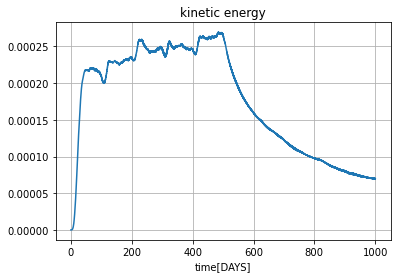

In [7]:
ax = r.stats["KINETIC_ENRG"].plot(title="kinetic energy")
#r.stats["KINETIC_ENRG"].plot(ax=ax, color="orange")
#r.stats["BTKIN_ENRG"].plot(ax=ax, lw=3., color=ax.get_lines()[-1].get_color(), 
#                           ls="--", label="barotropic")
ax.grid()

--- 

## pictures

### sea level

In [8]:
time_slice = np.arange(300,600,100)

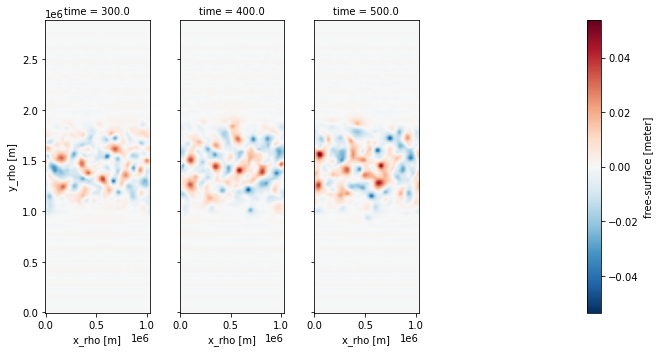

In [9]:
hdl = (r["surf"]["ssh"].sel(time=time_slice)
         .plot(x="x_rho", y="y_rho", col="time", col_wrap=4, 
               subplot_kws={"aspect":"equal"},
               aspect=.5, figsize=(10,5))
       )
plot_Fy(pout, ax=hdl.axes[0,-1])

### surface zonal velocity

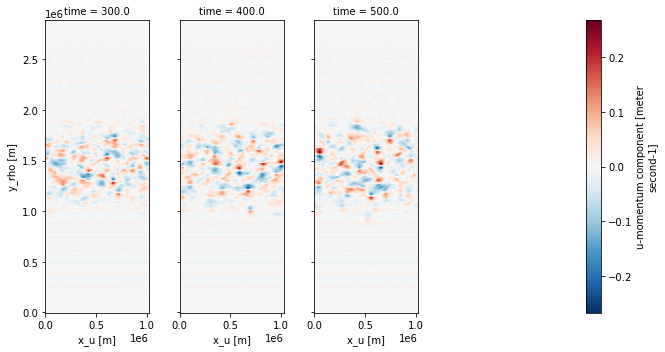

In [10]:
hdl = (r["surf"]["u"].sel(time=time_slice)
         .plot(x="x_u", y="y_rho", col="time", col_wrap=4, 
               subplot_kws={"aspect":"equal"},
               aspect=.5, figsize=(10,5))
)
plot_Fy(pout, ax=hdl.axes[0,-1])

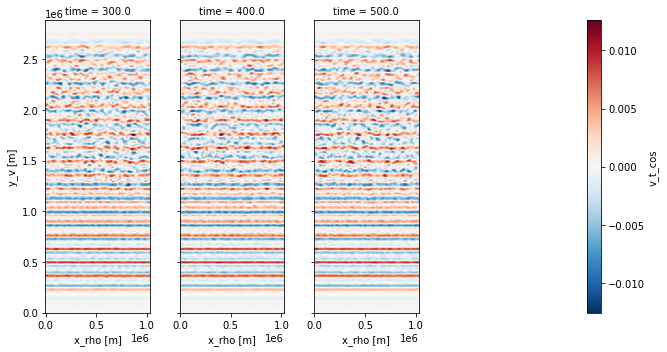

In [11]:
hdl = (r["his"]["v_t_cos"].sel(time=time_slice).sel(s_rho=0., method="nearest")
         .plot(x="x_rho", y="y_v", col="time", col_wrap=4, 
               subplot_kws={"aspect":"equal"},
               aspect=.5, figsize=(10,5))
       )
plot_Fy(pout, ax=hdl.axes[0,-1])

---

## vertical slices

In [52]:
z_u = r.get_z(zeta=r["his"].ssh_t_dirac, hgrid="u")
ds = r["his"].assign_coords(z_u = z_u)

In [53]:
time_slice = [320, 420, 520]

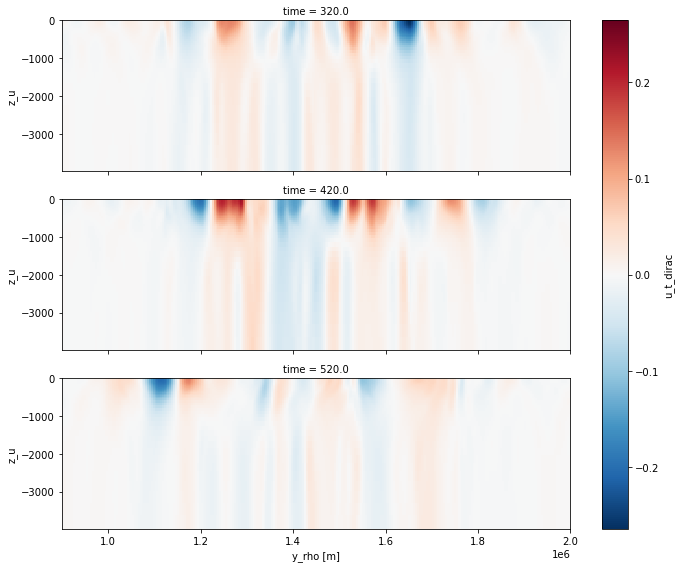

In [54]:
(ds.u_t_dirac
 .isel(x_u=0).sel(time=time_slice)
 .plot(x="y_rho", y="z_u", 
       xlim=(900*1e3,2000*1e3),
       figsize=(10,8),
       col="time", col_wrap=1)
)

---

## make movies

In [17]:
def atom(ax, da, ax_kwargs, test=None, **plt_kwargs):
    #
    xc = next((x for x in da.dims if x[0]=="x"), False)
    yc = next((x for x in da.dims if x[0]=="y"), False)
    da = da.assign_coords(x=da[xc]/1e3, y=da[yc]/1e3)
    #
    d = int(da.time)
    title = da.name+" day = %d"%(d)
    #h = (_da.time-d)*24
    #title = da.name+" day = %d / h = %.2f hour "%(d, h)
    #
    da.plot(x="x",y="y", ax=ax, **plt_kwargs)
    plot_Fy(pout, ax=ax, scale=1e-3)
    ax.set_aspect("equal", "box")
    ax.set(**ax_kwargs)
    ax.set_title(title)

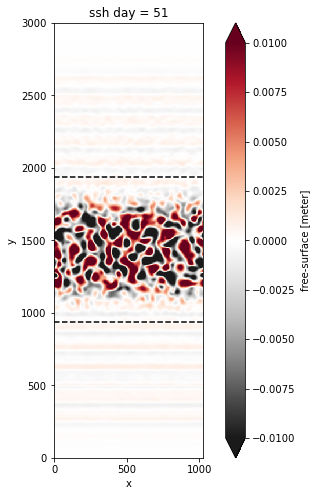

In [18]:
ssh = r["surf"]["ssh"]

da = ssh
plt_kw = {"vmin": -.01, "vmax": .01, "cmap": "RdGy_r", 
          "extend":"both"}
ax_kw = {"ylim": (0, 3000)}
cplt.movie_figure(atom, da, i=50, test=True, figsize=(8,8), 
                  ax_kwargs=ax_kw, **plt_kw)

In [19]:
cplt.movie_wrapper(atom, client, da,
                   figsize=(8,8),
                   ax_kwargs=ax_kw, 
                   **plt_kw)
# for some reason, breaks if on a local (1 node) cluster
# with typical matplotlib thread issue:
# https://github.com/pydata/xarray/issues/1889

28 batches to be done
 batch 0-35
 batch 36-71
 batch 72-107
 batch 108-143
 batch 144-179
 batch 180-215
 batch 216-251
 batch 252-287
 batch 288-323
 batch 324-359
 batch 360-395
 batch 396-431
 batch 432-467
 batch 468-503
 batch 504-539
 batch 540-575
 batch 576-611
 batch 612-647
 batch 648-683
 batch 684-719
 batch 720-754
 batch 755-789
 batch 790-824
 batch 825-859
 batch 860-894
 batch 895-929
 batch 930-964
 batch 965-999


---

## compute frequency spectra

In [13]:
# utility functions
from scipy import signal

def get_spectra_E(x, fs=None, ufunc=True, **kwargs):
    ax = -1 if ufunc else 0
    #
    dkwargs = {'window': 'hann', 'return_onesided': False, 
               'detrend': None, 'scaling': 'density'}
    dkwargs.update(kwargs)
    f, E = signal.welch(x, fs=fs, axis=ax, **dkwargs)
    #
    if ufunc:
        return E
    else:
        return f, E

def wrap_spectra(v, dt, f=None, **kwargs):
    v = v.chunk({'time': -1})
    _kwargs = {'fs': 1./dt}
    _kwargs.update(kwargs)
    if f is None:
        f, E = get_spectra_E(v.values, ufunc=False, **_kwargs)
        return f, E
    else:
        E = xr.apply_ufunc(get_spectra_E, v,
                           dask='parallelized', 
                           output_dtypes=[np.float64],
                           input_core_dims=[['time']],
                           output_core_dims=[['frequency']],
                           output_sizes={'frequency': _kwargs['nperseg']},
                           kwargs=_kwargs)
        return E.assign_coords(frequency=f).sortby('frequency')

In [14]:
#ds = r["surf"]

# tmp:
ds = r["sec"].isel(s_rho=-1)

dt = float((ds.time[1]-ds.time[0]).values)
T = 40
N = int(T/dt)

In [15]:
# tmp
u = ds.u_yz.rename(y_uy="y_rho").isel(y_rho=slice(0,-1))
v = ds.v_yz.rename(y_vy="y_rho")
v["y_rho"] = u["y_rho"]

In [16]:
#f, _ = wrap_spectra(ds.u.isel(x_rho=0,y_rho=0)+1j*ds.v.isel(x_rho=0,y_rho=0), dt, nperseg=N)
f, _ = wrap_spectra(u.isel(y_rho=0)+1j*v.isel(y_rho=0), dt, nperseg=N)
E = wrap_spectra(u+1j*v, dt, f=f, nperseg=N).persist()
E = E.rename("Euv")
E

/dev/shm/pbs.7616416.datarmor0/ipykernel_15101/1744815619.py:25: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  E = xr.apply_ufunc(get_spectra_E, v,
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask/array/utils.py:107: ComplexWarning: Casting complex values to real discards the imaginary part
  meta = meta.astype(dtype)


<xarray.DataArray 'Euv' (y_rho: 721, frequency: 960)>
dask.array<getitem, shape=(721, 960), dtype=float64, chunksize=(721, 960), chunktype=numpy.ndarray>
Coordinates:
    x_rhoy     float32 dask.array<chunksize=(), meta=np.ndarray>
    s_rho      float32 -0.01
  * y_rho      (y_rho) float32 -2e+03 2e+03 6e+03 ... 2.874e+06 2.878e+06
    x_uy       float32 dask.array<chunksize=(), meta=np.ndarray>
    x_vy       float32 dask.array<chunksize=(), meta=np.ndarray>
  * frequency  (frequency) float64 -12.0 -11.98 -11.95 ... 11.93 11.95 11.98

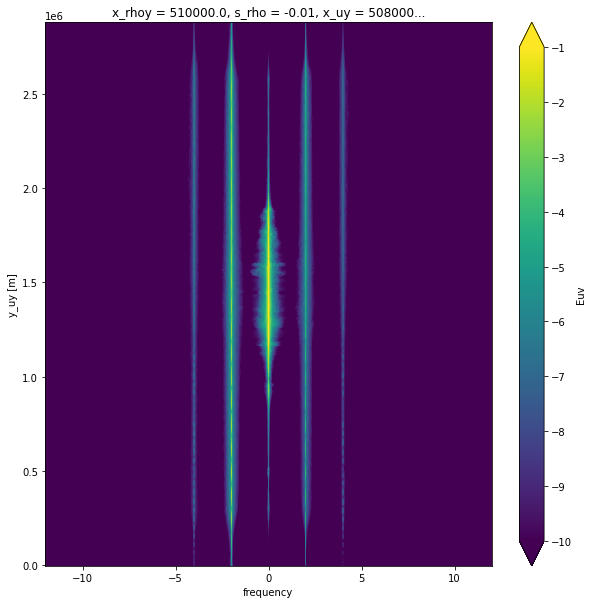

In [17]:
np.log10(E).plot(vmin=-10, vmax=-1, figsize=(10,10))

In [18]:
ds_E = E.to_dataset().reset_coords()["Euv"]
ds_E = ds_E.rename(y_rho="y")
ds_E["y"] = ds_E["y"]/1e3

r.store_diagnostic("spectra_uv_eulerian", 
                   ds_E, 
                   overwrite=True,
                  )

data stored in /home1/scratch/slgentil/fsturb_h500_a1_m0_4km_0a1000j/diagnostics/spectra_uv_eulerian.zarr


---

### compare spectra

In [25]:
H = [500, 10000]

E_e = {}
E_l = {}
for h in H:
    run = "fsturb_h{}_a1_m0_4km_0a1000j".format(h)
    r = pp.Run(root_path+run, outputs=["surf", "his", "sec"], 
               tdir_max=1,
               chunks=dict(sec=dict(time=2400, s_rho=1)),
               grid_periodicity=True, verbose=0)
    E_e[h] = r.load_diagnostic("spectra_uv_eulerian").persist()
    E_l[h] = r.load_diagnostic("spectra_uv_lagrangian_dt60").persist()

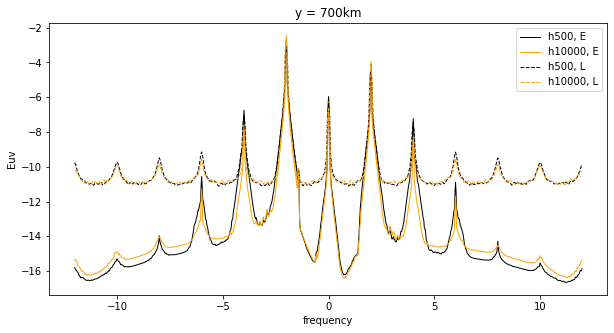

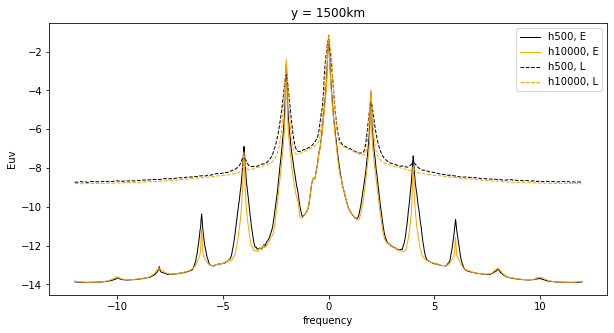

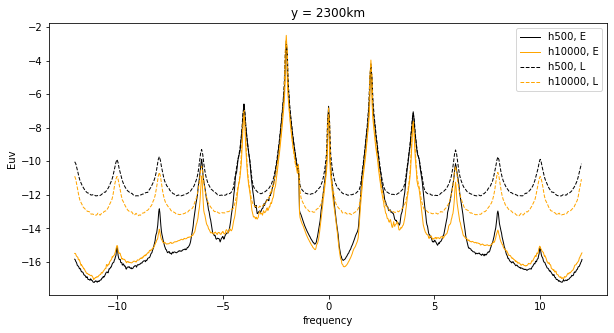

In [26]:
ys = [700, 1500, 2300]
dy = 100

lw = {500: 1, 10000:1}
color = {500: "k", 10000: "orange"}

for y in ys:
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    for h, E in E_e.items():
        _E = E.Euv.sel(y=slice(y-dy/2., y+dy/2.)).mean("y")
        np.log10(_E).plot(ax=ax, color=color[h], lw=lw[h], 
                          label="h{}, E".format(h))
    for h, E in E_l.items():
        _E = E.Euv.sel(y=slice(y-dy/2., y+dy/2.)).mean("y")
        np.log10(_E).plot(ax=ax, color=color[h], lw=lw[h], ls="--", 
                          label="h{}, L".format(h))
    ax.legend()
    ax.set_title("y = {}km".format(y))    

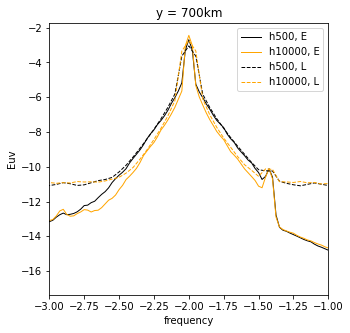

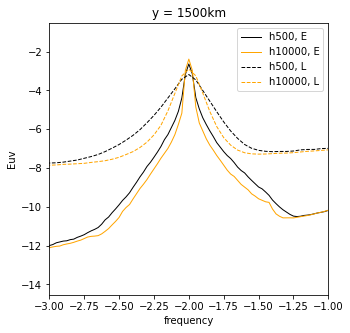

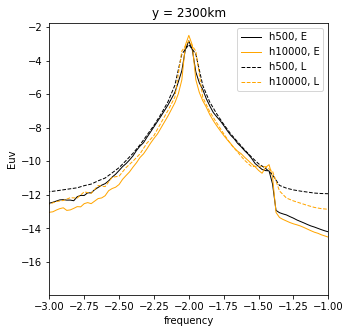

In [27]:
for y in ys:
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    for h, E in E_e.items():
        _E = E.Euv.sel(y=slice(y-dy/2., y+dy/2.)).mean("y")
        np.log10(_E).plot(ax=ax, color=color[h], lw=lw[h], 
                          label="h{}, E".format(h))
    for h, E in E_l.items():
        _E = E.Euv.sel(y=slice(y-dy/2., y+dy/2.)).mean("y")
        np.log10(_E).plot(ax=ax, color=color[h], lw=lw[h], ls="--", 
                          label="h{}, L".format(h))
    ax.set_xlim(-3,-1)
    ax.legend()
    ax.set_title("y = {}km".format(y))

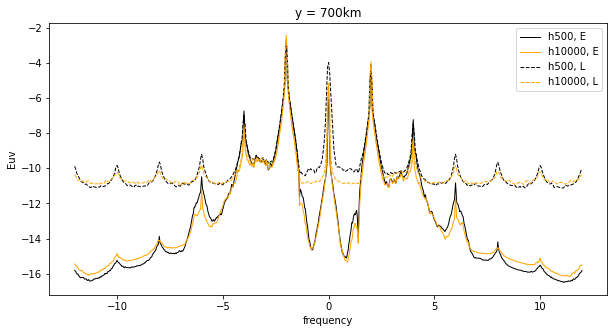

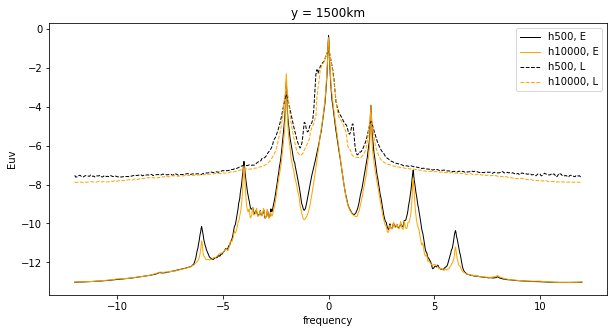

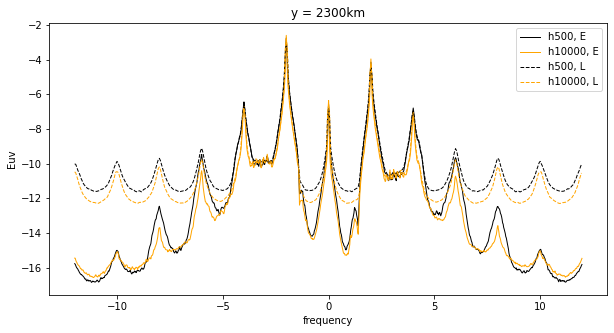

In [24]:
ys = [700, 1500, 2300]
dy = 100

lw = {500: 1, 10000:1}
color = {500: "k", 10000: "orange"}

for y in ys:
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    for h, E in E_e.items():
        _E = E.Euv.sel(y=slice(y-dy/2., y+dy/2.)).mean("y")
        np.log10(_E).plot(ax=ax, color=color[h], lw=lw[h], 
                          label="h{}, E".format(h))
    for h, E in E_l.items():
        _E = E.Euv.sel(y=slice(y-dy/2., y+dy/2.)).mean("y")
        np.log10(_E).plot(ax=ax, color=color[h], lw=lw[h], ls="--", 
                          label="h{}, L".format(h))
    ax.legend()
    ax.set_title("y = {}km".format(y))    

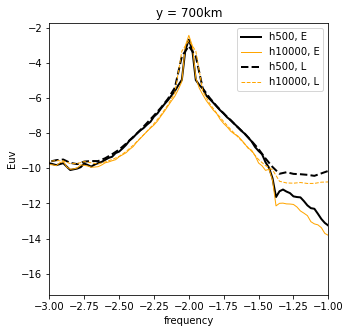

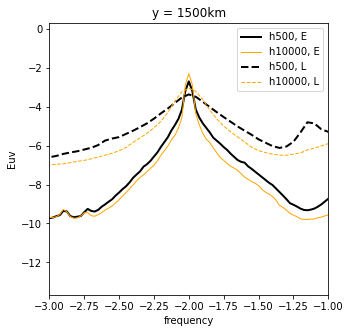

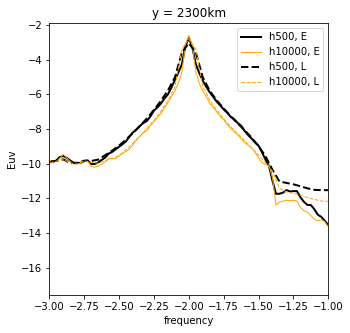

In [21]:
for y in ys:
    fig, ax = plt.subplots(1, 1, figsize=(5,5))
    for h, E in E_e.items():
        _E = E.Euv.sel(y=slice(y-dy/2., y+dy/2.)).mean("y")
        np.log10(_E).plot(ax=ax, color=color[h], lw=lw[h], 
                          label="h{}, E".format(h))
    for h, E in E_l.items():
        _E = E.Euv.sel(y=slice(y-dy/2., y+dy/2.)).mean("y")
        np.log10(_E).plot(ax=ax, color=color[h], lw=lw[h], ls="--", 
                          label="h{}, L".format(h))
    ax.set_xlim(-3,-1)
    ax.legend()
    ax.set_title("y = {}km".format(y))

---

In [20]:
cluster.close()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when 